##### Step 1: Import Required Libraries and Ising Solvers

In [ ]:
import torch
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# # Import the Ising Solvers (for running on device using 'Ising_Solvers.py', uncomment the next line)
# from Ising_Solvers import DOCH, ADOCH, compute_matrix_norms, generate_random_ising



# define the Ising Solvers (DOCH, ADOCH) and utility functions

class DOCH:
    """
    DOCH (Difference Of Convex Hamiltonian) solver for Ising model.
    """

    def __init__(self, device=None):
        """
        Initialize DOCH solver.

        Args:
            device: PyTorch device (cuda/cpu). Auto-detected if None.
        """
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def solve(self, J_mat, x0, eta, j_mat_2_norm, J_mat_1_norm, runtime):
        """Solve Ising model using DOCH.

        Args:
            J_mat: Coupling matrix.
            x0: Initial point.
            eta: Algorithm parameter.
            j_mat_2_norm: 2-norm of J.
            J_mat_1_norm: 1-norm of J.
            runtime: Maximum runtime.

        Returns:
            (energies, times, final_spins)
        """
        n = J_mat.shape[0]
        n_tensor = torch.tensor(n, device=self.device, dtype=torch.float32)

        # Step 1: Initialize parameters
        alpha = eta * j_mat_2_norm
        beta = n_tensor * torch.sqrt(n_tensor) * (alpha + J_mat_1_norm)

        energies = []
        times = []
        x = x0.clone()

        start_time = time.time()
        iterations = 0

        while time.time() - start_time < runtime:
            # Step 2: DOCH update rule
            J_x = J_mat @ x
            x = torch.sign(alpha * x + J_x) * (torch.abs((alpha * x + J_x) / beta))**(1/3)

            # Step 3: Compute energy and track progress
            spins = torch.sign(x)
            energy = -0.5 * (spins @ J_mat @ spins)

            energies.append(energy.item())
            times.append(time.time() - start_time)
            iterations += 1

            print(f'DOCH: {iterations} iter, {times[-1]:.3f}s, Energy: {energies[-1]:.3f}', end='\r')

        return energies, times, torch.sign(x)


class ADOCH:
    """
    ADOCH (Accelerated DOCH) solver for Ising model.
    """

    def __init__(self, device=None):
        """
        Initialize ADOCH solver.

        Args:
            device: PyTorch device (cuda/cpu). Auto-detected if None.
        """
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def solve(self, J_mat, x0, eta, j_mat_2_norm, J_mat_1_norm, runtime, q=10, T=5):
        """Solve Ising model using ADOCH.

        Args:
            J_mat: Coupling matrix.
            x0: Initial point.
            eta: Algorithm parameter.
            j_mat_2_norm: 2-norm of J.
            J_mat_1_norm: 1-norm of J.
            runtime: Maximum runtime.
            q: History window for adaptive restart.
            T: Number of DOCH iterations per step.

        Returns:
            (energies, times, final_spins)
        """
        n = J_mat.shape[0]
        n_tensor = torch.tensor(n, device=self.device, dtype=torch.float32)

        # Step 1: Initialize parameters
        alpha = eta * j_mat_2_norm
        beta = n_tensor * torch.sqrt(n_tensor) * (alpha + J_mat_1_norm)
        inv_beta = 1.0 / beta

        x = x0.clone()
        z = x0.clone()
        t_val = 1.0

        energies = []
        times = []
        x_history = []

        def compute_objective(x_input):
            """Objective function: G(x) - H(x)"""
            quadratic = 0.5 * x_input @ (alpha * x_input + (J_mat @ x_input))
            quartic = 0.25 * beta * torch.sum(x_input**4)
            return quartic - quadratic

        start_time = time.time()
        k = 0

        while time.time() - start_time < runtime:
            # Step 2: Compute momentum coefficient
            t_next = (1 + torch.sqrt(torch.tensor(1 + 4 * t_val**2,
                                               device=self.device, dtype=torch.float32))) / 2

            x_prev = x.clone()

            # Step 3: Momentum update
            if k > 0:
                z = x + ((t_val - 1) / t_next) * (x - x_prev)
            else:
                z = x.clone()

            # Step 4: Adaptive restart
            if k > q:
                F_z = compute_objective(z)
                start_idx = max(0, k - q)

                if start_idx < k:
                    F_values = torch.stack([compute_objective(x_history[i])
                                          for i in range(start_idx, k)])
                    F_max = torch.max(F_values)
                    v = z if F_z <= F_max else x
                else:
                    v = z
            else:
                v = x

            x = v.clone()

            # Step 5: T iterations of DOCH update
            for _ in range(T):
                numerator = alpha * x + (J_mat @ x)
                x = torch.sign(numerator) * torch.abs(numerator * inv_beta) ** (1/3)

            x_history.append(x.clone())
            t_val = t_next.item()

            # Compute energy and track progress
            spins = torch.sign(x)
            energy = -0.5 * (spins @ J_mat @ spins)

            elapsed_time = time.time() - start_time
            energies.append(energy.item())
            times.append(elapsed_time)

            print(f'ADOCH: {k+1} iter, {elapsed_time:.3f}s, Energy: {energy.item():.3f}', end='\r')
            k += 1

        return energies, times, torch.sign(x)


def compute_matrix_norms(J_mat):
    """
    Compute matrix norms needed for DOCH/ADOCH algorithms.

    Args:
        J_mat: Coupling matrix

    Returns:
        tuple: (matrix_1_norm, matrix_2_norm)
    """
    n = J_mat.shape[0]

    # 1-norm (maximum absolute column sum)
    J_mat_1_norm = torch.max(torch.abs(J_mat).sum(dim=0))

    # 2-norm calculation
    if n <= 1000:
        # Exact computation for small matrices
        j_mat_2_norm = torch.linalg.norm(J_mat, ord=2)
    else:
        # Wigner semicircle law approximation for large matrices
        j_mat_2_norm = 2 * math.sqrt(n) * torch.sqrt(
            torch.sum(J_mat**2)/(n*(n-1)) - (torch.sum(J_mat)/(n*(n-1)))**2
        )

    return J_mat_1_norm, j_mat_2_norm



def generate_random_ising(model, n, p=100.0, device=None):
    """
    Generate random symmetric Ising coupling matrix.

    Args:
        n: Matrix size
        model: 'sk' (Sherrington-Kirkpatrick) or 'fc' (Fully-Connected)
        p: Connectivity percentage (0 < p <= 100), percentage of nonzero couplings
        device: PyTorch device

    Returns:
        torch.Tensor: Symmetric coupling matrix with zero diagonal
    """
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if model not in ['sk', 'fc']:
        raise ValueError("Ising model must be 'sk (Sherrington-Kirkpatrick)' or 'fc' (Fully-Connected), else directly load J matrix.")
    elif model == 'sk':
        J_mat = torch.randn(n, n, device=device, dtype=torch.float32)
    else:
        J_mat = 2*torch.triu(torch.randint(0, 2, (n, n), device=device, dtype=torch.float32) * 2 - 1)

    # Make symmetric
    J_mat = (J_mat + J_mat.T)/2
    # Zero diagonal
    J_mat = J_mat - torch.diag(J_mat.diagonal())

    # Apply connectivity constraint
    if p < 100.0 and model != 'fc':
        # Create mask for upper triangular part (excluding diagonal)
        mask = torch.triu(torch.ones(n, n, device=device, dtype=torch.bool), diagonal=1)
        upper_indices = torch.where(mask)

        # Total number of upper triangular elements
        total_elements = n * (n - 1) // 2
        # Number of elements to keep
        keep_elements = int((p/100) * total_elements)

        # Randomly select indices to keep
        perm = torch.randperm(total_elements, device=device)
        keep_mask = torch.zeros(total_elements, device=device, dtype=torch.bool)
        keep_mask[perm[:keep_elements]] = True

        # Create sparsity mask
        sparsity_mask = torch.zeros(n, n, device=device, dtype=torch.bool)
        sparsity_mask[upper_indices[0][keep_mask], upper_indices[1][keep_mask]] = True
        # Make symmetric
        sparsity_mask = sparsity_mask | sparsity_mask.T

        # Apply mask
        J_mat = J_mat * sparsity_mask.float()

    return J_mat


# Set a random seed
torch.manual_seed(42)

# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count() if torch.cuda.is_available() else 0
print(f"Using device: {device} (Number of GPUs: {num_gpus})")

# Set default dtype and device for optimization
torch.set_default_dtype(torch.float32)
if device.type == 'cuda':
    torch.set_default_device(device)

Using device: cpu (Number of GPUs: 0)


##### Step 2: Generate Ising Model Data

In [ ]:
# Problem size - you can adjust this
n = 2000  # number of spins
p = 50.0  # Connectivity percentage (0 to 100%), only for model = 'sk'
model = 'sk'  # 'sk' for Sherrington-Kirkpatrick Ising model
# model = 'fc'   # fully-connected Ising model

print(f'Generating {model} Ising model data with {n} spins...')

# Generate random symmetric Ising matrix
J_mat = generate_random_ising(model, n, p, device)

print(f'Generated {n}x{n} symmetric coupling matrix')
print(f'Matrix properties:')
print(f'  - Shape: {J_mat.shape}')
print(f'  - Device: {J_mat.device}')
print(f'  - Data type: {J_mat.dtype}')
print(f'  - Non-zero elements: {torch.count_nonzero(J_mat).item()}')
print(f'  - Connectivity: {torch.count_nonzero(J_mat).item() / (n * (n-1)):.5%}')
print(f'  - Memory usage: {J_mat.element_size() * J_mat.nelement() / 1024**2:.1f} MB')

Generating sk Ising model data with 2000 spins...
Generated 2000x2000 symmetric coupling matrix
Matrix properties:
  - Shape: torch.Size([2000, 2000])
  - Device: cpu
  - Data type: torch.float32
  - Non-zero elements: 1999000
  - Connectivity: 50.00000%
  - Memory usage: 15.3 MB


##### Step 3: Compute Matrix Norms

In [ ]:
print('Computing matrix norms...')

# Compute required norms
J_mat_1_norm, j_mat_2_norm = compute_matrix_norms(J_mat)

print(f'Matrix 1-norm (max column sum): {J_mat_1_norm:.4f}')
print(f'Matrix 2-norm (spectral norm): {j_mat_2_norm:.4f}')

# These norms help determine algorithm stability and convergence

Computing matrix norms...
Matrix 1-norm (max column sum): 632.8547
Matrix 2-norm (spectral norm): 44.8086


##### Step 4: Set Algorithm Parameters

In [ ]:
# Runtime and tuning parameters
max_run_time = 1.0      # seconds for main algorithm run
max_tune_time = 0.1     # seconds for parameter tuning
tune_res = 3            # rounds of tuning

# Initialize random starting point
x0 = torch.randn(n, device=device, dtype=torch.float32)

print(f'Algorithm parameters:')
print(f'  - Main runtime: {max_run_time} seconds')
print(f'  - Tuning time per trial: {max_tune_time} seconds')
print(f'  - Tuning rounds: {tune_res}')
print(f'  - Starting point initialized with {n} random values')

# Initialize solvers
doch_solver = DOCH(device)
adoch_solver = ADOCH(device)
print('\nSolvers initialized successfully!')

Algorithm parameters:
  - Main runtime: 1.0 seconds
  - Tuning time per trial: 0.1 seconds
  - Tuning rounds: 3
  - Starting point initialized with 2000 random values

Solvers initialized successfully!


##### Step 5: DOCH Algorithm - Parameter Tuning

In [ ]:
print("Tuning DOCH algorithm parameters...")

# Initial eta range for DOCH
Eta = np.linspace(0.01, 2.01, 10)

best_energy = 0
E_DOCH_best = []
T_DOCH_best = []
eta_DOCH = Eta[0]

for round_num in range(tune_res):
    print(f"\nTuning round {round_num + 1}/{tune_res}")

    for idx, eta in enumerate(Eta):
        # Test this eta value
        E_test, T_test, _ = doch_solver.solve(J_mat, x0, eta, j_mat_2_norm, J_mat_1_norm, max_tune_time)

        if best_energy > E_test[-1]:  # Lower energy is better
            best_energy = E_test[-1]
            eta_DOCH = eta
            best_idx = idx
            E_DOCH_best = E_test
            T_DOCH_best = T_test

    # Refine search around best eta
    if best_idx == 0:
        Eta = np.linspace(Eta[best_idx]/2, Eta[best_idx], 10)
    elif best_idx == len(Eta)-1:
        Eta = np.linspace(Eta[best_idx], Eta[best_idx]*2, 10)
    else:
        Eta = np.linspace(Eta[best_idx-1], Eta[best_idx+1], 10)

    print(f'DOCH tuning round {round_num + 1}: tuned final Energy = {best_energy:.4f}')


Tuning DOCH algorithm parameters...

Tuning round 1/3
DOCH tuning round 1: tuned final Energy = -29731.2188

Tuning round 2/3
DOCH tuning round 2: tuned final Energy = -30709.0664

Tuning round 3/3
DOCH tuning round 3: tuned final Energy = -30847.6895


##### Step 6: Run DOCH Algorithm

In [ ]:
print("Running DOCH algorithm...")

start_time = time.time()
E_DOCH, T_DOCH, spins_DOCH = doch_solver.solve(J_mat, x0, eta_DOCH, j_mat_2_norm, J_mat_1_norm, max_run_time)
doch_runtime = time.time() - start_time

print(f"\nDOCH completed in {doch_runtime:.3f} seconds")
print(f"Final energy: {E_DOCH[-1]:.4f}")
print(f"Total iterations: {len(E_DOCH)}")

Running DOCH algorithm...
DOCH: 397 iter, 1.001s, Energy: -31264.779
DOCH completed in 1.003 seconds
Final energy: -31264.7793
Total iterations: 397


##### Step 7: ADOCH Algorithm - Parameter Tuning

In [ ]:
print("Tuning ADOCH algorithm parameters...")

# ADOCH typically works better with smaller eta values
Eta = np.linspace(0.01, 0.2, 10)

best_energy = 0
E_ADOCH_best = []
T_ADOCH_best = []
eta_ADOCH = Eta[0]

for round_num in range(tune_res):
    print(f"\nTuning round {round_num + 1}/{tune_res}")

    for idx, eta in enumerate(Eta):
        # Test this eta value
        E_test, T_test, _ = adoch_solver.solve(J_mat, x0, eta, j_mat_2_norm, J_mat_1_norm, max_tune_time)

        if best_energy > E_test[-1]:  # Lower energy is better
            best_energy = E_test[-1]
            eta_ADOCH = eta
            best_idx = idx
            E_ADOCH_best = E_test
            T_ADOCH_best = T_test

    # Refine search around best eta
    if best_idx == 0:
        Eta = np.linspace(Eta[best_idx]/2, Eta[best_idx], 10)
    elif best_idx == len(Eta)-1:
        Eta = np.linspace(Eta[best_idx], Eta[best_idx]*2, 10)
    else:
        Eta = np.linspace(Eta[best_idx-1], Eta[best_idx+1], 10)

    print(f'ADOCH tuning round {round_num + 1}: tuned final Energy = {best_energy:.4f}')


Tuning ADOCH algorithm parameters...

Tuning round 1/3
ADOCH tuning round 1: tuned final Energy = -31013.2773

Tuning round 2/3
ADOCH tuning round 2: tuned final Energy = -31111.4473

Tuning round 3/3
ADOCH tuning round 3: tuned final Energy = -31464.3594


##### Step 8: Run ADOCH Algorithm

In [ ]:
print("Running ADOCH algorithm...")

start_time = time.time()
E_ADOCH, T_ADOCH, spins_ADOCH = adoch_solver.solve(J_mat, x0, eta_ADOCH, j_mat_2_norm, J_mat_1_norm, max_run_time)
adoch_runtime = time.time() - start_time

print(f"\nADOCH completed in {adoch_runtime:.3f} seconds")
print(f"Final energy: {E_ADOCH[-1]:.4f}")
print(f"Total iterations: {len(E_ADOCH)}")

Running ADOCH algorithm...
ADOCH: 58 iter, 1.007s, Energy: -31544.725
ADOCH completed in 1.007 seconds
Final energy: -31544.7246
Total iterations: 58


##### Step 9: Compare Results

(The sparse matrix multiplication in PyTorch, used for speedup, involves randomization, so results may vary even with fixed seeds. Run it multiple times to observe differences.)

In [ ]:
print("ALGORITHM COMPARISON RESULTS")
print("=" * 28)

print(f"Problem size: {n} spins")
print(f"Runtime per algorithm: {max_run_time} seconds")
print("\nFinal Results:")
print(f"  DOCH  final energy: {E_DOCH[-1]:.6f}")
print(f"  ADOCH final energy: {E_ADOCH[-1]:.6f}")

# Convergence analysis
print(f"\nConvergence Analysis:")
print(f"  DOCH  iterations: {len(E_DOCH)}")
print(f"  ADOCH iterations: {len(E_ADOCH)}")

ALGORITHM COMPARISON RESULTS
Problem size: 2000 spins
Runtime per algorithm: 1.0 seconds

Final Results:
  DOCH  final energy: -31264.779297
  ADOCH final energy: -31544.724609

Convergence Analysis:
  DOCH  iterations: 397
  ADOCH iterations: 58


##### Step 10: Plot Results

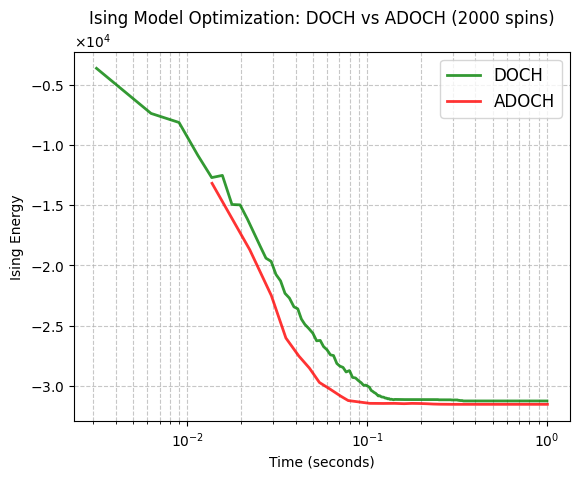

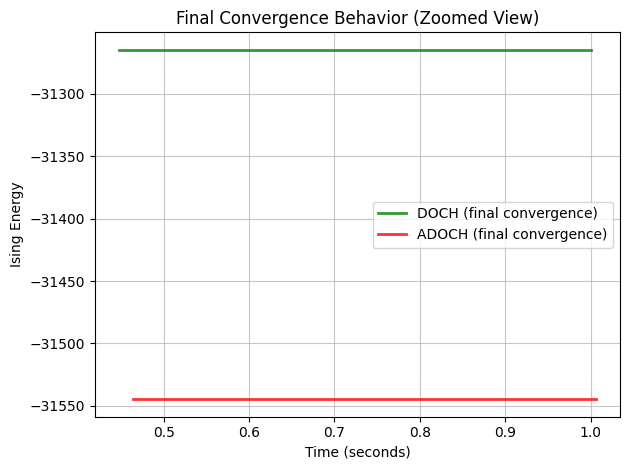

In [ ]:
# Main convergence plot
plt.figure()
plt.plot(T_DOCH, E_DOCH, label='DOCH', color='green', linewidth=2, alpha=0.8)
plt.plot(T_ADOCH, E_ADOCH, label='ADOCH', color='red', linewidth=2, alpha=0.8)

plt.xscale('log')
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Ising Energy')
plt.title(f'Ising Model Optimization: DOCH vs ADOCH ({n} spins)')
plt.legend(fontsize=12)

# Format y-axis for scientific notation
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
plt.gca().yaxis.set_major_formatter(formatter)

# Zoomed view of the final convergence
plt.figure()
# Show last 50% of the convergence
doch_start = len(T_DOCH) // 2
adoch_start = len(T_ADOCH) // 2

plt.plot(T_DOCH[doch_start:], E_DOCH[doch_start:], label='DOCH (final convergence)',
         color='green', linewidth=2, alpha=0.8)
plt.plot(T_ADOCH[adoch_start:], E_ADOCH[adoch_start:], label='ADOCH (final convergence)',
         color='red', linewidth=2, alpha=0.8)

plt.grid(True, alpha=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Ising Energy')
plt.title('Final Convergence Behavior (Zoomed View)', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()